# Translating Clinical Findings into Knowledge in Drug Safety Evaluation - Drug Induced Liver Injury Prediction System (DILIps)


This notebook analyzes clinical data for DILI and tries to reproduce Zhichao Liu models.
    
    Index:
            - Data Analysis: Side effects distribution, clustering and correlations.
            
            - Model building: Build models reproducing Liu ones, keeping only those with good quality metrics.
                  FLAME modeling framework is used in this step https://github.com/phi-grib/flame.
              
            - Model validation: Validate models using the same test set.
            
            - Analysis of side-effect importance. Which are the most related to DILI?
            
            - Discussion: Some text judging the results.
        
            


## Analysis of the dataset

In [289]:
import pandas as pd
from rdkit.Chem import PandasTools as pt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
from structure_resolver import * # homemade library to resolve structures from identifiers
                                # https://github.com/josecarlosgomezt/structure_search
from rdkit.Chem import AllChem
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import matthews_corrcoef as mcc

In [32]:
# Read the data with training set, sheet 0.
tong = pd.read_excel('tong_data.xls', 0)

In [33]:
tong.head()

,DrugbankID,Generic names,PubCID,bilirubinemia,cholecystitis,cholelithiasis,cirrhosis,elevated liver function tests,hepatic failure,hepatic necrosis,hepatitis,hepatomegaly,jaundice,liver disease,liver fatty,liver function tests abnormal,Combined Scores,Distribution_Status
0,DB00333,methadone,4095,0,0,0,0,0,0,0,0,0,0,0,0,0,0,training
1,DB00331,metformin,4091,0,0,0,0,0,0,0,1,0,0,0,0,1,2,training
2,DB00958,carboplatin,38904,0,0,0,0,0,0,0,0,0,0,0,0,1,1,training
3,DB00816,metaproterenol,4086,0,0,0,0,0,0,0,0,0,0,0,0,0,0,training
4,DB00933,mesoridazine,4078,0,0,0,0,0,0,0,0,0,1,0,0,0,1,training


In [34]:
# Distribution of number of side effects per compound.
tong['Combined Scores'].value_counts()

0     424
1     164
2     110
3      71
4      51
5      32
7      15
6      13
8       7
10      1
Name: Combined Scores, dtype: int64

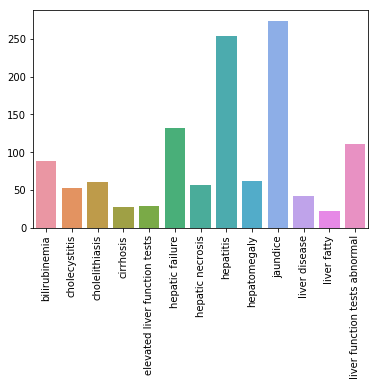

In [35]:
# Plot the distribution of side effects in the data. 
x = []
y = []
for col in tong.columns[3:16]:
    x.append(tong[col].value_counts()[1])
    y.append(col)
ax = sns.barplot(x=y, y=x)
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [36]:
# Get a subframe with only side effect columns
subframe = tong[tong.columns[3:16]]

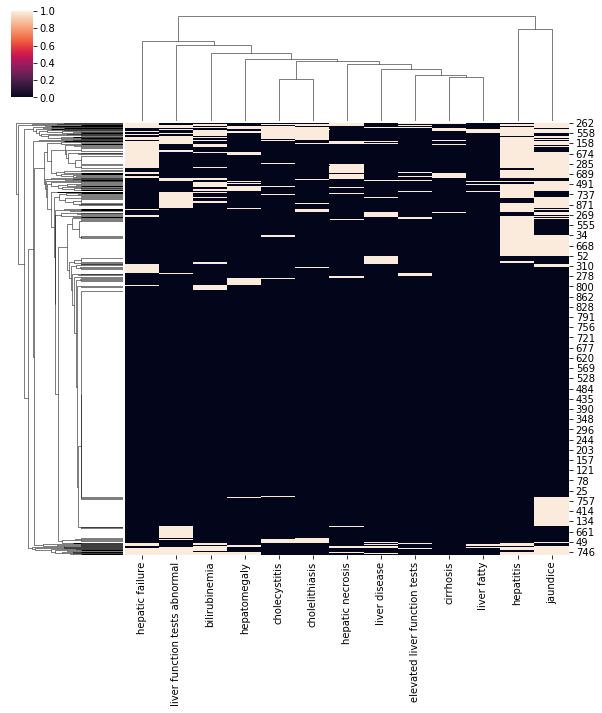

In [37]:
# Plot a clustermap of side effects.
cluster_map = sns.clustermap(subframe)

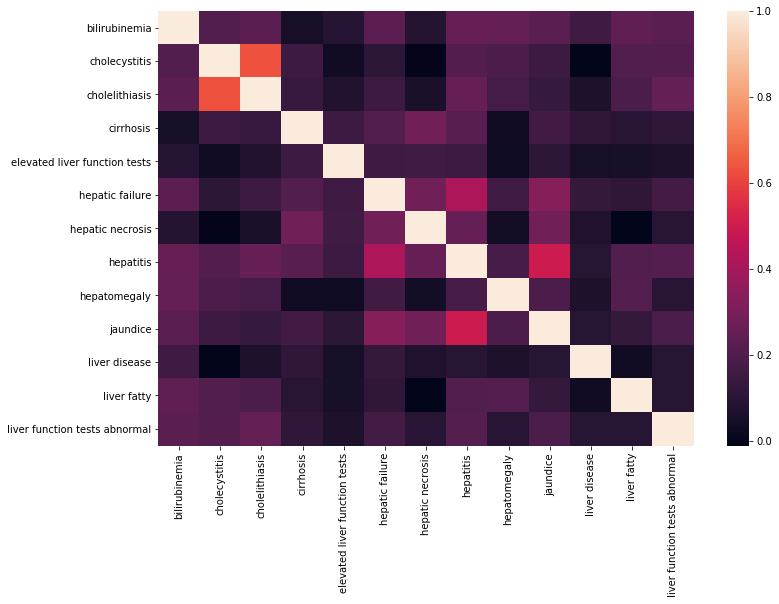

In [38]:
# Get the correlation matrix among side effects and plot it in a 
# heatmap
correlation = subframe.corr()
plt.figure(figsize=(12,8))
heatmap = sns.heatmap(correlation)

In [39]:
# Show correlation matrix
correlation.head()

,bilirubinemia,cholecystitis,cholelithiasis,cirrhosis,elevated liver function tests,hepatic failure,hepatic necrosis,hepatitis,hepatomegaly,jaundice,liver disease,liver fatty,liver function tests abnormal
bilirubinemia,1.000000,0.202805,0.226042,0.051020,0.087493,0.232219,0.084509,0.257112,0.249282,0.227218,0.156914,0.238100,0.227921
cholecystitis,0.202805,1.000000,0.632898,0.149182,0.033943,0.108524,-0.006695,0.208696,0.192116,0.150731,-0.011348,0.204498,0.206618
cholelithiasis,0.226042,0.632898,1.000000,0.135240,0.076750,0.152363,0.059362,0.256517,0.172719,0.130997,0.066834,0.188004,0.250970
cirrhosis,0.051020,0.149182,0.135240,1.000000,0.151966,0.202554,0.277841,0.221721,0.028692,0.165692,0.115030,0.098360,0.111553
elevated liver function tests,0.087493,0.033943,0.076750,0.151966,1.000000,0.154756,0.160853,0.150086,0.024246,0.110446,0.048603,0.052237,0.064658


In [40]:
## Lets add structures to the dataframe. If this step was already done
## go to the next section and load the sdf file

tong.shape

(888, 18)

In [41]:
# Get InChIs using homemade structure_resolver script
tong = add_inchis(tong, name='Generic names', DBID='DrugbankID')

  6%|▌         | 51/888 [00:14<02:34,  5.43it/s]

KeyboardInterrupt: 

In [ ]:
# Show entries with not found InChIs
tong[tong['InChI'] == False]

In [ ]:
# Discard InChIs
tong_clean = tong[tong['InChI'] != False]

In [ ]:
# Get MOls from InChIs
mols = []
for inchi in tong_clean['InChI']:
    mols.append(AllChem.MolFromInchi(inchi))
tong_clean['ROMol'] = mols

In [ ]:
# Discard entries with failed mol object retrieval

tong_clean = tong_clean[tong_clean['ROMol'].notnull()]
tong_clean.shape

In [ ]:
# Save the frame into a SDF file

pt.WriteSDF(tong_clean, 'tong_clean.sdf', properties=tong_clean.columns)

## Let's build and evaluate models for each DILI endpoints.

In [42]:
# Import Flame and RDKit libraries

from flame.build import Build
from flame.predict import Predict
from flame.manage import *
from rdkit.Chem import PandasTools as pt

In [43]:
# Load file (If created previously)

tong_clean = pt.LoadSDF('tong_clean.sdf')

,Combined Scores,Distribution_Status,DrugbankID,Generic names,ID,InChI,PubCID,ROMol,bilirubinemia,cholecystitis,cholelithiasis,cirrhosis,elevated liver function tests,hepatic failure,hepatic necrosis,hepatitis,hepatomegaly,jaundice,liver disease,liver fatty,liver function tests abnormal
0,0,training,DB00333,methadone,,"InChI=1S/C21H27NO/c1-5-20(23)21(16-17(2)22(3)4,18-12-8-6-9-13-18)19-14-10-7-11-15-19/h6-15,17H,5,16H2,1-4H3",4095,,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,training,DB00331,metformin,,"InChI=1S/C4H11N5/c1-9(2)4(7)8-3(5)6/h1-2H3,(H5,5,6,7,8)",4091,,0,0,0,0,0,0,0,1,0,0,0,0,1
2,1,training,DB00958,carboplatin,,"InChI=1S/C6H8O4.2H3N.Pt/c7-4(8)6(5(9)10)2-1-3-6;;;/h1-3H2,(H,7,8)(H,9,10);2*1H3;/q;;;+2/p-2",38904,,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,training,DB00816,metaproterenol,,"InChI=1S/C11H17NO3/c1-7(2)12-6-11(15)8-3-9(13)5-10(14)4-8/h3-5,7,11-15H,6H2,1-2H3",4086,,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,training,DB00933,mesoridazine,,"InChI=1S/C21H26N2OS2/c1-22-13-6-5-7-16(22)12-14-23-18-8-3-4-9-20(18)25-21-11-10-17(26(2)24)15-19(21)23/h3-4,8-11,15-16H,5-7,12-14H2,1-2H3",4078,,0,0,0,0,0,0,0,0,0,1,0,0,0

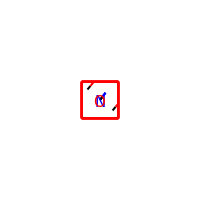
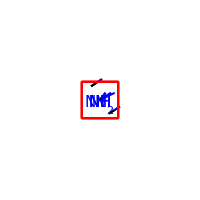
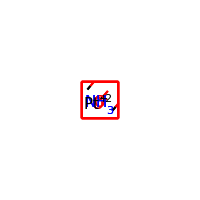
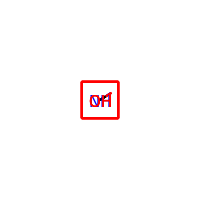
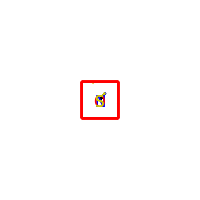

In [44]:
tong_clean.head()

In [46]:
# Function to set parameters and build the model
def build_model(end):
    # Instantiate flame Build class
    build = Build(end)
    # Set model parameters
    build.param.setVal('conformal', True)
    build.param.setVal('verbose_error', False)
    build.param.setVal('tune', True)
    build.param.setVal('ModelValidationCV', 'loo')
    build.param.setVal('ModelValidationN', 10)
    build.param.setVal('computeMD_method', ['RDKit_md'])
    build.param.setVal('quantitative', False)
    build.param.setVal('modelAutoscaling', True)
    build.param.setVal('model', 'RF')
    build.param.setVal('imbalance', 'simple_subsampling')
    build.param.setVal('SDFile_activity', end)
    build.param.update_file(end,)
    build.run(f'sdfs/{end}.sdf')

In [61]:
# Create endpoint separate files to create Flame models.
endpoints = tong_clean.columns[8:]
for end in endpoints:
    print(end)
    sdf = tong_clean[tong_clean[end].notnull()]
    pt.WriteSDF(sdf, f'./sdfs/{end}.sdf', properties=sdf.columns)

bilirubinemia
cholecystitis
cholelithiasis
cirrhosis
elevated liver function tests
hepatic failure
hepatic necrosis
hepatitis
hepatomegaly
jaundice
liver disease
liver fatty
liver function tests abnormal


In [62]:
# Build models for each endpoint and add reliable models
# to a list (reliable are models with MCC>0.3)

DILI_reliable = []  # List with good built DILI models
for end in endpoints[:]:
    # Create a new endpoint
    action_new(end)
    # action_remove(end, 1)  # Remove version, if rebuilding model
    os.system('rm ./sdfs/data.pkl') # Remove data created for other model
    build_model(end)
    results = np.asarray(json.loads(action_results(end, 0)[1])['model_valid_info'], dtype=object)
    # Get cross-validation MCC
    mcc = np.where(results[:, 0] == 'MCC') #  Returns the 2D indexex to whre MCC is located
    mcc = results[mcc[0]][0][2]  # Get the row where MCC is, and then get the actual value.
    if mcc >= 0.3:  # keep only models with MCC higher than 0.3
        DILI_reliable.append(end)
        action_publish(end)  # Publish the model 
    else:
        action_kill(end)


INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers
INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #7 mol0000000007. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #73 mol0000000073. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #121 mol0000000121. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #123 mol0000000123. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule whe

       nobj ( number of objects ) : 884.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 44.0
       TN ( True negatives in cross-validation ) : 42.0
       FP ( False positives in cross-validation ) : 13.0
       FN ( False negatives in cross-validation ) : 11.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.8
       Specificity ( Specificity in cross-validation ) : 0.7636
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.564
       Conformal_coverage ( Conformal coverage ) : 0.625
       Conformal_accuracy ( Conformal accuracy ) : 0.7818


INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers
INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #7 mol0000000007. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #73 mol0000000073. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #121 mol0000000121. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #123 mol0000000123. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule whe

       nobj ( number of objects ) : 884.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 10.0
       TN ( True negatives in cross-validation ) : 10.0
       FP ( False positives in cross-validation ) : 7.0
       FN ( False negatives in cross-validation ) : 7.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.5882
       Specificity ( Specificity in cross-validation ) : 0.5882
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.1765
       Conformal_coverage ( Conformal coverage ) : 0.3208
       Conformal_accuracy ( Conformal accuracy ) : 0.5882


INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #7 mol0000000007. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #73 mol0000000073. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #121 mol0000000121. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #123 mol0000000123. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #275 mol0000000275. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #300 mol0000000300. Skipping nor

       nobj ( number of objects ) : 884.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 14.0
       TN ( True negatives in cross-validation ) : 13.0
       FP ( False positives in cross-validation ) : 8.0
       FN ( False negatives in cross-validation ) : 7.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.6667
       Specificity ( Specificity in cross-validation ) : 0.619
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.286
       Conformal_coverage ( Conformal coverage ) : 0.35
       Conformal_accuracy ( Conformal accuracy ) : 0.6429


INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers
INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #7 mol0000000007. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #73 mol0000000073. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #121 mol0000000121. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #123 mol0000000123. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule whe

       nobj ( number of objects ) : 884.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 8.0
       TN ( True negatives in cross-validation ) : 7.0
       FP ( False positives in cross-validation ) : 2.0
       FN ( False negatives in cross-validation ) : 6.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.5714
       Specificity ( Specificity in cross-validation ) : 0.7778
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.3438
       Conformal_coverage ( Conformal coverage ) : 0.4259
       Conformal_accuracy ( Conformal accuracy ) : 0.6522


INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers
INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #7 mol0000000007. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #73 mol0000000073. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #121 mol0000000121. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #123 mol0000000123. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule whe

       nobj ( number of objects ) : 884.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 8.0
       TN ( True negatives in cross-validation ) : 3.0
       FP ( False positives in cross-validation ) : 3.0
       FN ( False negatives in cross-validation ) : 4.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.6667
       Specificity ( Specificity in cross-validation ) : 0.5
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.1612
       Conformal_coverage ( Conformal coverage ) : 0.3103
       Conformal_accuracy ( Conformal accuracy ) : 0.6111


INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #7 mol0000000007. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #73 mol0000000073. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #121 mol0000000121. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #123 mol0000000123. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #275 mol0000000275. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #300 mol0000000300. Skipping nor

       nobj ( number of objects ) : 884.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 47.0
       TN ( True negatives in cross-validation ) : 38.0
       FP ( False positives in cross-validation ) : 23.0
       FN ( False negatives in cross-validation ) : 17.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.7344
       Specificity ( Specificity in cross-validation ) : 0.623
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.3598
       Conformal_coverage ( Conformal coverage ) : 0.4735
       Conformal_accuracy ( Conformal accuracy ) : 0.68


INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers
INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #7 mol0000000007. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #73 mol0000000073. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #121 mol0000000121. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #123 mol0000000123. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule whe

       nobj ( number of objects ) : 884.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 17.0
       TN ( True negatives in cross-validation ) : 11.0
       FP ( False positives in cross-validation ) : 6.0
       FN ( False negatives in cross-validation ) : 9.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.6538
       Specificity ( Specificity in cross-validation ) : 0.6471
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.295
       Conformal_coverage ( Conformal coverage ) : 0.3839
       Conformal_accuracy ( Conformal accuracy ) : 0.6512


INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers
INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #7 mol0000000007. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #73 mol0000000073. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #121 mol0000000121. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #123 mol0000000123. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule whe

       nobj ( number of objects ) : 884.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 114.0
       TN ( True negatives in cross-validation ) : 101.0
       FP ( False positives in cross-validation ) : 47.0
       FN ( False negatives in cross-validation ) : 42.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.7308
       Specificity ( Specificity in cross-validation ) : 0.6824
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.4138
       Conformal_coverage ( Conformal coverage ) : 0.5984
       Conformal_accuracy ( Conformal accuracy ) : 0.7072


INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers
INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #7 mol0000000007. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #73 mol0000000073. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #121 mol0000000121. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #123 mol0000000123. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule whe

       nobj ( number of objects ) : 884.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 16.0
       TN ( True negatives in cross-validation ) : 11.0
       FP ( False positives in cross-validation ) : 12.0
       FN ( False negatives in cross-validation ) : 5.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.7619
       Specificity ( Specificity in cross-validation ) : 0.4783
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.2494
       Conformal_coverage ( Conformal coverage ) : 0.3548
       Conformal_accuracy ( Conformal accuracy ) : 0.6136


INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers
INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #7 mol0000000007. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #73 mol0000000073. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #121 mol0000000121. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #123 mol0000000123. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule whe

       nobj ( number of objects ) : 884.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 132.0
       TN ( True negatives in cross-validation ) : 100.0
       FP ( False positives in cross-validation ) : 51.0
       FN ( False negatives in cross-validation ) : 43.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.7543
       Specificity ( Specificity in cross-validation ) : 0.6623
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.4186
       Conformal_coverage ( Conformal coverage ) : 0.5971
       Conformal_accuracy ( Conformal accuracy ) : 0.7117


INFO - New model version created from /data/jcgomez/projects/internals/flame/flame/flame/models/jaundice/dev to /data/jcgomez/projects/internals/flame/flame/flame/models/jaundice/ver000002
INFO - New endpoint liver disease created
INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers
INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #7 mol0000000007. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #73 mol0000000073. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #121 mol0000000121. Skipping norm

       nobj ( number of objects ) : 884.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 8.0
       TN ( True negatives in cross-validation ) : 6.0
       FP ( False positives in cross-validation ) : 7.0
       FN ( False negatives in cross-validation ) : 9.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.4706
       Specificity ( Specificity in cross-validation ) : 0.4615
       MCC ( Matthews Correlation Coefficient in cross-validation ) : -0.0673
       Conformal_coverage ( Conformal coverage ) : 0.3571
       Conformal_accuracy ( Conformal accuracy ) : 0.4667


INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #7 mol0000000007. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #73 mol0000000073. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #121 mol0000000121. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #123 mol0000000123. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #275 mol0000000275. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #300 mol0000000300. Skipping nor

       nobj ( number of objects ) : 884.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 0.0
       TN ( True negatives in cross-validation ) : 1.0
       FP ( False positives in cross-validation ) : 4.0
       FN ( False negatives in cross-validation ) : 2.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.0
       Specificity ( Specificity in cross-validation ) : 0.2
       MCC ( Matthews Correlation Coefficient in cross-validation ) : -0.7303
       Conformal_coverage ( Conformal coverage ) : 0.1591
       Conformal_accuracy ( Conformal accuracy ) : 0.1429


INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #7 mol0000000007. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #73 mol0000000073. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #121 mol0000000121. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #123 mol0000000123. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #275 mol0000000275. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #300 mol0000000300. Skipping nor

       nobj ( number of objects ) : 884.0
       nvarx ( number of predictor variables ) : 200.0
       model ( model type ) : RF qualitative (optimized)
       model ( model type ) : conformal RF qualitative
       TP ( True positives in cross-validation ) : 18.0
       TN ( True negatives in cross-validation ) : 13.0
       FP ( False positives in cross-validation ) : 16.0
       FN ( False negatives in cross-validation ) : 13.0
       Sensitivity ( Sensitivity in cross-validation ) : 0.5806
       Specificity ( Specificity in cross-validation ) : 0.4483
       MCC ( Matthews Correlation Coefficient in cross-validation ) : 0.0292
       Conformal_coverage ( Conformal coverage ) : 0.2703
       Conformal_accuracy ( Conformal accuracy ) : 0.5167


In [286]:
 #  Get validation statistics from built models
lista = []
columns = ['Endpoint']
for index, end in enumerate(DILI_reliable):

    results = json.loads(action_results(end, 1)[1])['model_valid_info']
    if index == 0:
        for el in results:
            columns.append(el[0])
    values = [end]
    for el in results:
        values.append(el[-1])
    print(columns)
    print(values)
    lista.append(values)
frame = pd.DataFrame(lista, columns=columns)
    
    
    

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [285]:
# Show models sorted by their MCC
frame.sort_values(by=['MCC'], ascending=[False])

KeyError: 'MCC'

In [42]:
frame.to_csv("models_DILI_mechinistic.csv")

## Load validation set (LTKB)

In [290]:
# Read validation set used by Zhichao Liu et Al. (subset of LTKB dataset)
ltkb = pd.read_excel('tong_data.xls', 1)

In [291]:
ltkb.head()

,DrugBank ID,Drug Name,DILI Label Sections,CAS No.,PubCID,DILI Endpoints,Distribution_Status,#models incriminating a drug as DILI positive in DILIps,DILI positive/negative as observed
0,DB00437,allopurinol,Warnings and Precautions,315-30-0,2094,Less-DILI-concern,(Not used) training,0,ambiguous call
1,DB00915,amantadine,Warnings and Precautions,768-94-5,2130,Less-DILI-concern,(Not used) training,0,ambiguous call
2,DB01060,amoxicillin,Warnings and Precautions,26787-78-0,33613,Less-DILI-concern,(Not used) training,1,ambiguous call
3,DB00993,azathioprine,Warnings and Precautions,446-86-6,2265,Less-DILI-concern,(Not used) training,0,ambiguous call
4,DB00958,carboplatin,Warnings and Precautions,41575-94-4,498142,Less-DILI-concern,(Not used) training,0,ambiguous call


In [292]:
ltkb.shape

(286, 9)

In [293]:
# Add InChIs to the dataframe and discard entries with no InChI
ltkb = add_inchis(ltkb, name='Drug Name', CASRN='CAS No.', DBID='DrugBank ID')
ltkb = ltkb[ltkb['InChI'] != False]
ltkb.shape


100%|██████████| 286/286 [01:11<00:00,  6.20it/s]

(286, 10)

In [20]:
# Get MOls from InChIs
mols = []
for inchi in ltkb['InChI']:
    mols.append(AllChem.MolFromInchi(inchi))
ltkb['ROMol'] = mols

In [24]:
# Get validation entries from Tong and discard Less-DILI-concern entries
validation = ltkb[ltkb['Distribution_Status'].str.contains('validation')]
validation = validation[validation['DILI Endpoints'] != 'Less-DILI-concern']
validation.shape


(73, 11)

In [27]:
# Check if there is training/test sets overlap
drugbdb = tong['PubCID'].tolist()
validation[validation['PubCID'].isin(drugbdb)]

,DrugBank ID,Drug Name,DILI Label Sections,CAS No.,PubCID,DILI Endpoints,Distribution_Status,#models incriminating a drug as DILI positive in DILIps,DILI positive/negative as observed,InChI,ROMol


In [28]:
# Save test set to a SDF file
pt.WriteSDF(validation, 'ltkb_val.sdf', properties=validation.columns)

/home/jcgomez/anaconda3/envs/flame/lib/python3.6/site-packages/rdkit/Chem/PandasTools.py:410: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(type(cell_value), float):


In [14]:
### Compute predictions

In [156]:
# Read info on created models
model_list = pd.read_csv('models_DILI_mechinistic.csv')
model_list.head(20)

,Unnamed: 0,Endpoint,TP,TN,FP,FN,Sensitivity,Specificity,MCC,Conformal_coverage,Conformal_accuracy
0,0,bilirubinemia,36,43,19,10,0.782609,0.693548,0.470984,0.613636,0.731481
1,1,cirrhosis,8,7,2,6,0.571429,0.777778,0.343792,0.425926,0.652174
2,2,hepatic failure,50,38,25,16,0.757576,0.603175,0.365529,0.488636,0.682171
3,3,hepatitis,114,101,47,42,0.730769,0.682432,0.413785,0.598425,0.707237
4,4,jaundice,134,104,54,48,0.736264,0.658228,0.395732,0.622711,0.700000


In [15]:
# Function to set paramters of predict and predict activities 
# for a given endpoint
def predict_mols(end):
    # Instatiate predict class
    pred = Predict(end, 0)
    # Set predict parameters to match build (this won't be necessary soon)
    pred.param.setVal('conformal', True)
    pred.param.setVal('computeMD_method', ['RDKit_properties', 'RDKit_md'])
    pred.param.setVal('quantitative', False)
    pred.param.setVal('modelAutoscaling', True)
    pred.param.setVal('model', 'RF')
    pred.param.setVal('imbalance', 'simple_subsampling')
    pred.param.setVal('SDFile_activity', end)
    results = pred.run(f'processed_data/train_test_sets/{end}/{end}_test.sdf')
    return resultsmodels_DILI_mechinistic.csv

In [221]:
# Testing

model_list['version'] = 2

In [133]:
def get_predictions(models_frame,file,  name_col, version_col):
    model_predictions = pd.DataFrame()
    for model, version in zip(models_frame[name_col], models_frame[version_col]):
        pred =  Predict(model, version)
        results = pred.run(file)
        results = json.loads(results[1])
        c0 = np.asarray(results['c0'])
        c1 = np.asarray(results['c1'])
        final = []
        for val, val2 in zip(c0, c1):
            if val and not val2:
                final.append(0)
            elif val2 and not val:
                final.append(1)
            else:
                final.append(2)
        model_predictions[model + '-' + str(version)] = final
    return model_predictions
        

In [222]:
# Get prediction of a set of compounds for a given list of models. Endpoint and version column names
# needed. Returns a dataframe with predictions for each endpoint as columns
frame_pred = get_predictions(model_list, 'ltkb_val.sdf', 'Endpoint', 'version')

INFO - Running with input type: molecule
INFO - Recycling data from data.pkl
INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers
INFO - Starting normalization...


       obj_num ( number of objects ) : 73.0


ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #41 mol0000000041. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #43 mol0000000043. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #69 mol0000000069. Skipping normalization
INFO - Computing molecular descriptors with methods ['RDKit_md']...
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers


       obj_num ( number of objects ) : 73.0


INFO - Starting normalization...
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #41 mol0000000041. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #43 mol0000000043. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #69 mol0000000069. Skipping normalization
INFO - Computing molecular descriptors with methods ['RDKit_md']...
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers
INFO - Starting normalization...


       obj_num ( number of objects ) : 73.0


ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #41 mol0000000041. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #43 mol0000000043. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #69 mol0000000069. Skipping normalization
INFO - Computing molecular descriptors with methods ['RDKit_md']...
INFO - Computing RDKit descriptors...
INFO - Running with input type: molecule
WARNING - Unable to log syserror, this probably means flame is called from an ipython interactive terminal. Otherwise, please notify the developers
INFO - Starting normalization...


       obj_num ( number of objects ) : 73.0


ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #27 mol0000000027. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #41 mol0000000041. Skipping normalization
ERROR - Critical standardize exception: Multiple non-salt/solvate components when processing mol #43 mol0000000043. Skipping normalization
ERROR - Critical standardize exception: Time taken shows problem with moleule when processing mol #69 mol0000000069. Skipping normalization
INFO - Computing molecular descriptors with methods ['RDKit_md']...
INFO - Computing RDKit descriptors...


       obj_num ( number of objects ) : 73.0


In [ ]:
# Get consensus prediction. Here the rules to class assignment. 
def get_consensus(frame_pred):
    consensus = []
    for index, row in frame_pred.iterrows():
        val = 0
        # Get number of positive, negative and out of AD
        # predictions

        counts = row.value_counts().to_dict()
        if 1 in counts.keys():
            val = 1
            try:
                if counts[0] > counts[1]:
                    val = 0
            except:
                pass
        else:
            if 0 in counts.keys():
                val = 0
            else:
                val = 2

        consensus.append(val)
            

In [224]:
# Plot frame with different endpoint predictions
frame_pred.head(10)

,bilirubinemia-2,cirrhosis-2,hepatic failure-2,hepatitis-2,jaundice-2
0,1,2,1,2,1
1,0,1,2,2,2
2,2,2,0,2,2
3,0,1,1,2,2
4,2,1,1,1,1
5,0,1,1,1,1
6,0,1,2,1,1
7,2,1,2,2,2
8,2,1,2,2,2
9,0,1,1,1,1


In [189]:
# Get consensus prediction. Here the rules to class assignment. 
consensus = []
for index, row in frame_pred.iterrows():
    val = 0
    # Get number of positive, negative and out of AD
    # predictions
    
    counts = row.value_counts().to_dict()
    if 1 in counts.keys():
        val = 1
        try:
            if counts[0] > counts[1]:
                val = 0
        except:
            pass
    else:
        if 0 in counts.keys():
            val = 0
        else:
            val = 2
        
    consensus.append(val)
            

{1: 3, 2: 2}
{2: 3, 1: 1, 0: 1}
{2: 4, 0: 1}
{2: 2, 1: 2, 0: 1}
{1: 4, 2: 1}
{1: 4, 0: 1}
{1: 3, 2: 1, 0: 1}
{2: 4, 1: 1}
{2: 4, 1: 1}
{1: 4, 0: 1}
{2: 3, 0: 2}
{1: 3, 2: 1, 0: 1}
{1: 2, 0: 2, 2: 1}
{1: 4, 2: 1}
{2: 5}
{1: 4, 2: 1}
{2: 4, 1: 1}
{2: 3, 1: 1, 0: 1}
{2: 4, 1: 1}
{0: 3, 1: 2}
{2: 4, 1: 1}
{1: 4, 2: 1}
{1: 3, 2: 2}
{2: 3, 1: 1, 0: 1}
{0: 3, 2: 2}
{1: 4, 0: 1}
{2: 3, 0: 2}
{2: 3, 1: 1, 0: 1}
{2: 4, 0: 1}
{2: 4, 0: 1}
{1: 3, 2: 1, 0: 1}
{2: 3, 1: 2}
{2: 4, 1: 1}
{2: 3, 0: 2}
{2: 2, 1: 2, 0: 1}
{0: 3, 2: 2}
{2: 4, 0: 1}
{2: 2, 0: 2, 1: 1}
{2: 2, 1: 2, 0: 1}
{2: 3, 0: 2}
{1: 4, 2: 1}
{0: 3, 2: 2}
{2: 3, 1: 2}
{2: 3, 1: 1, 0: 1}
{2: 2, 1: 2, 0: 1}
{2: 4, 0: 1}
{1: 4, 2: 1}
{2: 3, 1: 2}
{1: 4, 2: 1}
{2: 3, 1: 2}
{0: 3, 2: 2}
{1: 4, 2: 1}
{1: 3, 2: 2}
{2: 3, 0: 2}
{1: 5}
{2: 4, 1: 1}
{2: 4, 0: 1}
{1: 3, 2: 2}
{0: 3, 2: 2}
{2: 2, 1: 2, 0: 1}
{2: 3, 1: 2}
{2: 4, 0: 1}
{1: 3, 2: 2}
{2: 3, 1: 2}
{1: 3, 2: 2}
{2: 5}
{2: 3, 1: 2}
{0: 3, 2: 1, 1: 1}
{2: 3, 0: 2}
{2: 3, 0: 2}
{2: 3, 0: 2}

In [190]:
# Create a new dataframe with consensus predictions and experimental values
frame = pd.DataFrame()
frame['ltkb'] = validation['DILI positive/negative as observed']
frame['pred'] = consensus
print(len(frame))
# Discard compounds out of the AD
ad_in = frame[frame['pred'] != 2]
print(len(ad_in))

In [225]:
matthew = mcc(ad_in['pred'].tolist(), ad_in['ltkb'].tolist(), )
TN, FP, FN, TP = cm(ad_in['pred'].tolist(), ad_in['ltkb'].tolist()).ravel()
sensitivity = (TP / (TP + FP))
specificity = (TN / (TN + FN))
print('MCC: ', matthew)
print('Sens: ', sensitivity)
print('Spec: ', spe.0cificity)

MCC:  0.41212395446777156
Sens:  0.7076923076923077
Spec:  1.0


## Now lets analyze variable importance using PLS



In [ ]:
from sklearn.cross_decomposition import PLSRegression


In [228]:
# Get X and Y values

X = frame_pred.values
Y = frame['ltkb'].values

In [227]:
pls = PLSRegression(n_components=2)

In [229]:
proyection = pls.fit_transform(X=X,y=Y)

In [278]:
'''Loadings plot. Addapted from PCA plotting code snippet found in StackOverflow'''
def myplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    sns.scatterplot(xs * scalex,ys * scaley, hue=Y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1),
                     color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i],
                     color='g', ha='center', va ='center')


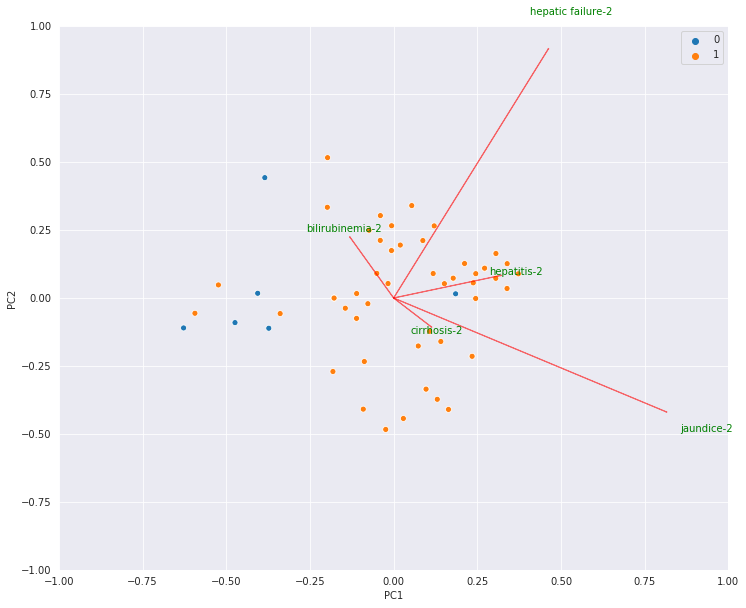

In [284]:
plt.figure(figsize=(12,10))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(proyection[0][:,0:2],(pls.x_loadings_), frame_pred.columns)
plt.show()

In [265]:
(pls.x_loadings_)

array([[-0.12940725,  0.22230782],
       [ 0.11129249, -0.1051178 ],
       [ 0.4613726 ,  0.91492941],
       [ 0.31896747,  0.08271601],
       [ 0.81295502, -0.41819477]])

## Discussion

Available hepatotoxic data from SIDER extracted by Zhichao Liu et all was used in order to reproduce DILI prediction models.
Distribution among side effects show 2 main properties. Data is unbalanced and different endpoints are not quite correlated.

Model building shows that, in contrast with the resulst obtainded by Zhichao Liu, not very good performance at crossvalidation, with
only 5 models with reasonable qualitity (when Zhichao Liu ones were almost perfect). In this case Kfold=5. Even trying to reproduce Zhichao Liu models
using the same algorithm (Gaussian Naive Bayes) and descriptors (circular FCFP) results in very poor performance. 
However, external validation using the same data shows that models built here outperform Zhichao Liu ones.

Also, variable importance analysis using PLS points out hepatic-failure and jaundice as the most informative varibles to classify a compound 
as hepatotoxic or not.